In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import least_squares as lsq
import random
random.seed(4321)
np.random.seed(1234)

In [2]:
PolRel = pd.read_excel("Seshat_PolityRelationData.xlsx")
Data = pd.read_csv("Seshat Data.csv")
Parameters_and_Times = np.loadtxt("Parameters_and_Times.txt")
RelTimeDF = pd.read_csv("RelTime_TimeSeries_SPC1.csv", index_col = 0)
RelTimeCCDF = pd.read_csv("RelTime_TimeSeries_CC.csv")
Parameters = Parameters_and_Times[:4]
Times = Parameters_and_Times[4:]
T = 5000

In [3]:
def f(x, a, b, c, d):
    # the logistic function in its most general shape, scaled by T=5000
    return a / (1. + np.exp(-c * (x - d))) + b

In [4]:
del RelTimeCCDF["Unnamed: 0"]

In [5]:
set(Data["NGA"]).issubset(set(PolRel["NGA"]))

True

In [6]:
# Discard superfluous NGAs
SubsetNGA = np.array(PolRel["NGA"].isin(set(Data["NGA"])))
PolRel = PolRel.iloc[SubsetNGA]


In [7]:
PolRel.head(50)

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
21,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland II,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [8]:
for i in list(set(PolRel["Dupl"])):
    print(i,sum(PolRel["Dupl"] == i))

y 103
n 596


In [9]:
# relationship to preceding (quasi)polity

for v in list(set(PolRel["Variable"])):
    print(v, sum(PolRel["Variable"]==v))

# Logical for Variable is the relationship
VR = PolRel["Variable"] == "relationship to preceding (quasi)polity"

Previous = PolRel.loc[np.logical_not(VR)]
Relationships = PolRel.loc[VR]

relationship to preceding (quasi)polity 335
succeeding (quasi)polity 364


In [10]:
Previous.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN


In [11]:
Relationships.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
23,Cahokia,USMisMu,Cahokia - Late Woodland II,450.0,600.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [12]:
for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )
                

vassalage 1
not applicable 2
continuation 7
elite migration 40
cultural assimilation 25
replacement 1
continunity 4
continuity 228
suspected unknown 2
indigenous revolt 1
Continuity 9
contination 1
Continuation 1
population migration 13


In [13]:
# Ever

Relationships["Value.From"].replace("Continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continunity", "continuity", inplace = True)
Relationships["Value.From"].replace("contination", "continuity", inplace = True)
Relationships["Value.From"].replace("Continuity", "continuity", inplace = True)

                
for val in list(set(Relationships["Value.From"])):
    if val != "continuity":
        Relationships["Value.From"].replace(val, "discontinuity", inplace = True)

for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )    

continuity 250
discontinuity 85


C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [14]:
CleanRel = pd.concat((Previous,Relationships), sort=False).sort_index()

In [15]:
CleanRel.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN


In [16]:
TimeZero = pd.read_csv("TimeZero.csv")
TimeZero.head()

,Unnamed: 0,Ghanaian Coast,Kansai,Paris Basin,Latium,Cambodian Basin,Middle Yellow River Valley,Upper Egypt,Central Java,Cuzco,Kachi Plain,Niger Inland Delta,Deccan,Iceland,Sogdiana,Yemeni Coastal Plain,Konya Plain,Orkhon Valley,Susiana
0,T0,1800,400,-200,-700,300,-1800,-3100,800,1400,-2500,1000,-300,1300,-500,400,-2000,500,-3700


In [17]:

# Again Discard superfluous NGAs
SubsetNGA_2 = np.array(Relationships["NGA"].isin(set(TimeZero.columns)))
Relationships = Relationships.iloc[SubsetNGA_2]

set(Relationships["NGA"]).issubset( set(TimeZero.columns))


True

In [18]:
Relationships["Polity.End.Scaled"] = 0

# iterate over all rows in the DF
for i in range(Relationships.shape[0]):
    n = Relationships["NGA"].iloc[i]
    
    # for this NGA: read its Time_Zero from the TimeZero.csv
    T_zero = TimeZero[n]
    # Shift the time accordingly
    Relationships["Polity.End.Scaled"].iloc[i] = Relationships["Polity.End"].iloc[i] - T_zero
    

C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [19]:
from scipy.stats import gaussian_kde
KDE = gaussian_kde(Relationships["Polity.End.Scaled"])
time_range = np.arange(-6000,6000,10)
KDE_t = KDE(time_range)

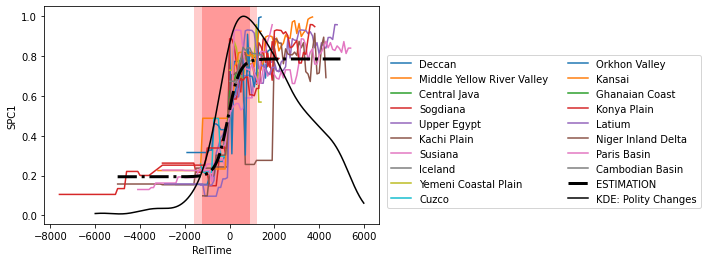

In [20]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE: Polity Changes")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)


plt.show()

## Normalise the Number of Polity Changes

Divide it by the number of existing polities at RelTime T, because if there are only few polities at an early time, we would also only expect few possible polity changes.

In [21]:
T_min, T_max = min(RelTimeDF["RelTime"]), max(RelTimeDF["RelTime"])

In [22]:
NumberPol = pd.DataFrame(columns=["RelTime", "NumberPol"])
for t in np.arange(T_min, T_max+100, 100):
    #print(t)
    #print(sum(RelTimeDF["RelTime"]==t))
    NumberPol = pd.concat([NumberPol,
                         pd.DataFrame({"RelTime": [t],
                                      "NumberPol": [sum(RelTimeDF["RelTime"]==t)]})])
NumberPol

,RelTime,NumberPol
0,-7600,1
0,-7500,1
0,-7400,1
0,-7300,1
0,-7200,1
...,...,...
0,5000,1
0,5100,1
0,5200,1
0,5300,1


In [23]:
NumberPol["NumberPol"].loc[NumberPol["RelTime"]==1000]

0    13
Name: NumberPol, dtype: object

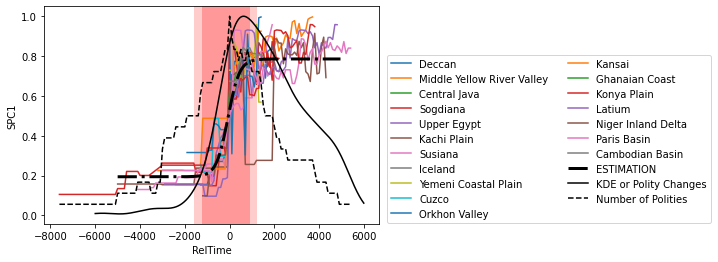

In [24]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE or Polity Changes")

plt.plot(NumberPol["RelTime"], NumberPol["NumberPol"]/np.max(NumberPol["NumberPol"]), "--", c="k",
        label="Number of Polities")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)

plt.show()

## Deal with the Continuity of Polities

In [25]:
 # this DF tells is, if a polity in an NGA is continuous or not
print(Relationships)
print(sorted(list(set(Relationships["NGA"])))) # only the long-lived ones remain

                      NGA    PolID               Longform.Name  Polity.Start  \
42        Cambodian Basin  KhFunaE                     Funan I         225.0   
44        Cambodian Basin  KhFunaL                    Funan II         540.0   
46        Cambodian Basin  KhChenl                      Chenla         550.0   
49        Cambodian Basin  KhAngkE                Early Angkor         802.0   
51        Cambodian Basin  KhAngkC            Classical Angkor        1100.0   
..                    ...      ...                         ...           ...   
830           Upper Egypt  TrOttm3           Ottoman Empire II        1517.0   
834           Upper Egypt  TrOttm4          Ottoman Empire III        1683.0   
858  Yemeni Coastal Plain  YeQasmi     Yemen - Qasimid Dynasty        1637.0   
861  Yemeni Coastal Plain  TrOttm4          Ottoman Empire III        1683.0   
862  Yemeni Coastal Plain  YeOttoL  Ottoman Empire Late Period        1873.0   

     Polity.End Dupl            Section

In [26]:
print(Relationships[["NGA", "Polity.End.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"].iloc[50:70])

             NGA  Polity.End.Scaled
580     Sogdiana              -50.0
587     Sogdiana              529.0
593     Sogdiana             1061.0
606     Sogdiana             1712.0
699      Susiana             1617.0
708      Susiana             2300.0
710      Susiana             2500.0
713      Susiana             2600.0
726      Susiana             3740.0
744      Susiana             4762.0
745      Susiana             4762.0
746      Susiana             4857.0
747      Susiana             4857.0
754      Susiana             5039.0
756      Susiana             5039.0
757      Susiana             5201.0
764      Susiana             5422.0
765      Susiana             5625.0
784  Upper Egypt             2353.0
788  Upper Egypt             2575.0


In [27]:
Breakpoints = Relationships[["NGA", "Polity.End.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"]
Breakpoints.columns = ["NGA", "RelTime"]
Breakpoints.head()

,NGA,RelTime
67,Central Java,718.0
138,Cuzco,-751.0
142,Cuzco,-401.0
145,Cuzco,-150.0
149,Cuzco,132.0


In [28]:
# Get the snippet that includes RelTime=0 and does not have any discontinuity
def Cutout(nga, df = RelTimeDF):
    
    
    Output = df.loc[df["NGA"]==nga]
    
    # if the nga has a discontinuous breakpoint, we need to cut out the central part of Output around 0
    if nga in set(Breakpoints["NGA"]):
        
        # get this nga's breakpoints
        BPs = Breakpoints.loc[Breakpoints["NGA"] == nga]
        
        
        # isolate the first breakpoint above zero
        # NOT exactly zero, because a breakpoint at zero means that up to RelTime 0, the polity has changed
        BP_positive = BPs.loc[BPs["RelTime"] > 0]
        
        if BP_positive.shape[0]>0: # is there any Breakpoint after 0?
            BP_end = min(BP_positive["RelTime"])
        else:
            BP_end = np.infty # else: latest possible year
        
        # Now need the beginning of the cutout-area, i.e. the last breakpoint before BP_end
        BP_rest = BPs.loc[BPs["RelTime"] < BP_end]
        
        
        if BP_rest.shape[0] > 0: # is there even a breakpoint before this?
            BP_start = max(BP_rest["RelTime"])
        else:
            BP_start = -np.inf # else: set the earliest possible time as beginning for the cutout
    
        print("BPs",BPs)
        print(BP_start,BP_end)
        
        Output = Output.loc[Output["RelTime"] > BP_start-1 ]
        Output = Output.loc[Output["RelTime"] < BP_end +1 ]
        
    return(Output)

In [29]:
## Test
Cutout_DF = pd.DataFrame(columns = RelTimeDF.columns)
Cutout_CCDF = pd.DataFrame(columns = RelTimeCCDF.columns)

for n in list(set(RelTimeDF["NGA"])):
    print(Cutout(n))
    Cutout_DF = pd.concat((Cutout_DF, Cutout(n)))
    Cutout_CCDF = pd.concat((Cutout_CCDF, Cutout(n, RelTimeCCDF)))

BPs         NGA  RelTime
166  Deccan   1273.0
173  Deccan   1627.0
174  Deccan   1946.0
-inf 1273.0
        NGA  RelTime      SPC1
527  Deccan    -2400  0.155157
528  Deccan    -2300  0.155157
529  Deccan    -2200  0.155157
530  Deccan    -2100  0.155157
531  Deccan    -2000  0.155157
532  Deccan    -1900  0.155157
533  Deccan    -1800  0.155157
534  Deccan    -1700  0.155157
535  Deccan    -1600  0.155157
536  Deccan    -1500  0.155157
537  Deccan    -1400  0.155157
538  Deccan    -1300  0.155157
539  Deccan    -1200  0.155157
540  Deccan    -1100  0.155157
541  Deccan    -1000  0.155157
542  Deccan     -900  0.196013
543  Deccan     -800  0.196013
544  Deccan     -700  0.196013
545  Deccan     -600  0.270682
546  Deccan     -500  0.270682
547  Deccan     -400  0.270682
548  Deccan     -300  0.270682
549  Deccan     -200  0.309012
550  Deccan     -100  0.309012
551  Deccan        0  0.865242
552  Deccan      100  0.309012
553  Deccan      200  0.772671
554  Deccan      300  0.773019
5

BPs                     NGA  RelTime
457  Niger Inland Delta   -951.0
476  Niger Inland Delta    712.0
-951.0 712.0
BPs                     NGA  RelTime
457  Niger Inland Delta   -951.0
476  Niger Inland Delta    712.0
-951.0 712.0
BPs              NGA  RelTime
521  Paris Basin  -1800.0
533  Paris Basin   -125.0
540  Paris Basin    484.0
541  Paris Basin    484.0
542  Paris Basin    484.0
543  Paris Basin    484.0
544  Paris Basin    484.0
552  Paris Basin    743.0
-125.0 484.0
             NGA  RelTime      SPC1
164  Paris Basin     -100  0.451406
165  Paris Basin        0  0.499567
166  Paris Basin      100  0.554045
167  Paris Basin      200  0.926779
168  Paris Basin      300  0.931205
169  Paris Basin      400  0.929827
BPs              NGA  RelTime
521  Paris Basin  -1800.0
533  Paris Basin   -125.0
540  Paris Basin    484.0
541  Paris Basin    484.0
542  Paris Basin    484.0
543  Paris Basin    484.0
544  Paris Basin    484.0
552  Paris Basin    743.0
-125.0 484.0
BPs           

In [30]:
Cutout_DF, Cutout_CCDF


(                 NGA RelTime      SPC1
 527           Deccan   -2400  0.155157
 528           Deccan   -2300  0.155157
 529           Deccan   -2200  0.155157
 530           Deccan   -2100  0.155157
 531           Deccan   -2000  0.155157
 ..               ...     ...       ...
 250  Cambodian Basin    1100  0.812885
 251  Cambodian Basin    1200  0.810691
 252  Cambodian Basin    1300  0.806051
 253  Cambodian Basin    1400  0.806733
 254  Cambodian Basin    1500  0.797299
 
 [365 rows x 3 columns],
                  NGA RelTime      SPC1    PolPop   PolTerr    CapPop  \
 527           Deccan   -2400  0.155157  2.731672  2.649571  3.150524   
 528           Deccan   -2300  0.155157  2.731672  2.649571  3.150524   
 529           Deccan   -2200  0.155157  2.731672  2.649571  3.150524   
 530           Deccan   -2100  0.155157  2.731672  2.649571  3.150524   
 531           Deccan   -2000  0.155157  2.731672  2.649571  3.150524   
 ..               ...     ...       ...       ...      

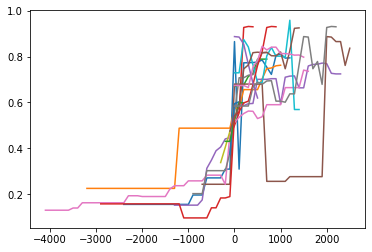

In [31]:
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"])
plt.show()

### Dan's Questions

Do large NGAs reach the SPC1 threshold again after a decline?

In [58]:
DF_Second = Cutout_DF.loc[Cutout_DF["RelTime"]>-1]
DF_Second.loc[DF_Second["SPC1"]< 0.49] # this is the SPC_Break from the other notebook

,NGA,RelTime,SPC1
552,Deccan,100,0.309012
469,Kachi Plain,700,0.255631
470,Kachi Plain,800,0.255631
471,Kachi Plain,900,0.255631
472,Kachi Plain,1000,0.255631
473,Kachi Plain,1100,0.255631
474,Kachi Plain,1200,0.276092
475,Kachi Plain,1300,0.276092
476,Kachi Plain,1400,0.276092
477,Kachi Plain,1500,0.276092


So indeed, the Orkhon Valley experiences a decline in SPC1 below the threshold after a discontinuous polity change!

In [61]:
# analyse this further
RelTimeDF.loc[RelTimeDF["NGA"] == "Orkhon Valley"]

,NGA,RelTime,SPC1
641,Orkhon Valley,-1900,0.315541
642,Orkhon Valley,-1800,0.315541
643,Orkhon Valley,-1700,0.315541
644,Orkhon Valley,-1600,0.315541
645,Orkhon Valley,-1500,0.315541
646,Orkhon Valley,-1400,0.315541
647,Orkhon Valley,-1300,0.315541
648,Orkhon Valley,-1200,0.315541
649,Orkhon Valley,-1100,0.315541
650,Orkhon Valley,-1000,0.315541


# Redo the RelTime Analysis with this Data?

## Fitting

In [33]:
X, y = Cutout_DF["RelTime"].to_numpy(), Cutout_DF["SPC1"].to_numpy()
T = 5000
X = np.array(list(X)) # for some reason, this transformation is necessary
X = X/T # normalisation of the data

def f(x, a, b, c, d):
    # the logistic function in its most general shape
    return a / (1. + np.exp(-c * (x - d))) + b

(a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, p0 = Parameters)

P0 = np.array((a_, b_, c_, d_))
print(P0)

[ 5.05526189e-01  2.04512959e-01  4.20835765e+01 -2.17749683e-02]


In [34]:
# comparison with full data:
Parameters

array([ 5.91641013e-01,  1.93784865e-01,  1.93749265e+01, -1.54321380e-02])

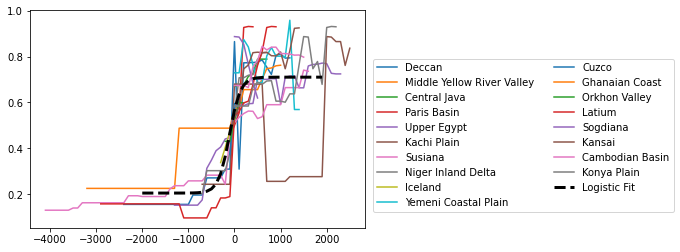

In [35]:
Cutout_DF
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"], label=n)

TimeRange = np.arange(-2000,2000,100)
New_Fit = f(TimeRange/T, a_, b_, c_, d_)
plt.plot(TimeRange, New_Fit, "--",label="Logistic Fit", c="k", linewidth = 3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.show()

## Out-of-Sample prediction
To evaluate quality of the fit.

In [36]:
L = len(Cutout_DF["RelTime"].to_numpy())
def RhoSq(y_hat, y_true): # like in Turchin's original PCA paper
    y_mean = np.mean(y_true)
    return(1 - sum((y_hat-y_true)**2)/sum((y_mean-y_true)**2)  )

In [37]:
C_list = list()
RhoSqList = list()
n_split = 1000
for i in range(1000):
    
    Selection = np.random.choice(np.arange(L), size = int(L/2), replace = False)
    
    X_train = X[Selection]
    y_train = y[Selection]
    
    test_indx = np.ones(len(X), bool)
    test_indx[Selection]=0
    y_test = y[test_indx]
    X_test = X[test_indx]
    
    (a1_, b1_, c1_, d1_), _ = opt.curve_fit(f, X_train, y_train,
                                            p0 = Parameters) # initial guess to ensure c > 0
    #print((a1_, b1_, c1_, d1_))
    C_list.append(c1_)
    RhoSqList.append(RhoSq( f(X_test, a1_, b1_, c1_, d1_), y_test))
    

In [38]:
print(np.mean(RhoSqList), np.median(RhoSqList), np.std(RhoSqList))

0.7492505433606959 0.7512516521226789 0.0309300321862778


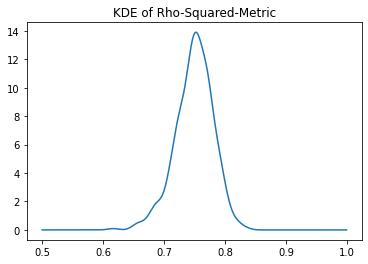

In [39]:
plt.plot(np.arange(0.5,1,0.001),
    gaussian_kde(RhoSqList)(np.arange(0.5,1,0.001)))
plt.title("KDE of Rho-Squared-Metric")
plt.show()

## Bootstrapping

First round of bootstrap: estimate many parameter values for a and b and the standard deviations for a, b a+b. This allows to compute the thresholds of the plateaus.

In [40]:
np.random.seed(1234)
random.seed(1234)
nBT = 1000 # how many Bootstraps
negCcount = 0

Params = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters
NGA_list = list(set(Cutout_DF["NGA"]))


for i in range(nBT):
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection:
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0

    Params = pd.concat([Params,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_]})])
    if c_ < 0:
        print(NGA_selection)
        negCcount +=1
        for N in NGA_selection:
            DF = Data_RT[Data_RT["NGA"] == N]
            plt.plot(DF["RelTime"]/T,    # ALSO normalised
            DF["SPC1"], label=N)
            plt.plot(x_show, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # FOR FULL DATA
            plt.plot(x_show, f(x_show, a_, b_, c_, d_), "-.",c="r", linewidth = 3)

        plt.show()
        
    print(a_, b_, c_, d_)
    print("-----------------")
print(Params.round(2))

0.5712661810730858 0.18931160210855255 26.779471150548076 -0.021155566817284765
-----------------
0.5501522764666225 0.20230157140027924 15.884470410801352 -0.03408751019547134
-----------------
0.5396818653319351 0.17275315927976728 41.978997153414525 -0.021895492157884874
-----------------
0.530753012611777 0.19059249276846887 61.91626323744194 -0.023848574650412697
-----------------
0.47879735098429205 0.21309739097425456 94.14206114404912 -0.02253477711962863
-----------------
0.43491204775606335 0.2521345390440352 40.56420638275918 -0.025810055142703337
-----------------
0.46645176296905644 0.2452393054975986 67.18295356920429 -0.017282603310803637
-----------------
0.5317509977548982 0.18863828813160013 52.95532662259376 -0.013724531109689202
-----------------
0.5622094033518829 0.19805560822699197 22.33245165126136 -0.027734741107927317
-----------------
0.4392464622454728 0.21619706776278957 57.792279347018 -0.019792210244433575
-----------------
0.5562603797934691 0.2080664377

C:\Users\Tobias\AppData\Local\Temp/ipykernel_23168/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.5058644480373377 0.21245953012721636 42.61192342535834 -0.015013329981409435
-----------------
0.49807840983716006 0.19747211753728527 54.98400724030369 -0.02164616500251082
-----------------
0.5051460467312211 0.17653111218136677 58.07613524684654 -0.019760094239771594
-----------------
0.4692842829546909 0.22962730181145038 32.414900764824026 -0.032021593233576305
-----------------
0.4234505885016754 0.24031747651160618 52.89221472351956 -0.028022849136926747
-----------------
0.5285870524309135 0.18843055984569831 58.32332578067071 -0.016519972711207625
-----------------
0.6021438383947569 0.15593003162092622 24.5237889639296 -0.021095824149360728
-----------------
0.5888273055607874 0.18068139760016622 32.80498862769929 -0.013780006833405677
-----------------
0.46224251560698426 0.22175863831581585 46.585876348474095 -0.023609191147414284
-----------------
0.5757439729162023 0.19552401060683502 17.636404326128076 -0.02709883728641294
-----------------
0.4789423630719004 0.2478902

0.4516897949476793 0.25559017630306125 50.46901435510566 -0.022403954997176064
-----------------
0.5684426006544389 0.19733911811141136 40.045558445204016 -0.016010203751777925
-----------------
0.5523752748337019 0.16541439721909576 34.677111371014476 -0.02985531530271793
-----------------
0.45340189160198724 0.20317650534087392 57.84468932371527 -0.01971881171644725
-----------------
0.5125609013485088 0.17544008673166625 33.585022565792045 -0.027639035614184418
-----------------
0.48730147025440257 0.22926826364961267 40.184236531007194 -0.01898337981090962
-----------------
0.5347584771107604 0.16983025025303186 34.137393013558025 -0.026108256567066983
-----------------
0.47172090693158475 0.19931151851069676 53.663973282329785 -0.0263839889691909
-----------------
0.46178110222287755 0.25601922139006406 67.15935513356952 -0.013484145791629546
-----------------
0.48965359381024465 0.2277280339388513 73.65872292538293 -0.018728000898839362
-----------------
0.6113132161844861 0.2019

0.49365742320879313 0.19805787306297584 155.61599110846166 -0.015568862523326007
-----------------
0.534429037929174 0.22453154171961562 30.390850043928122 -0.023592055488333548
-----------------
0.4743548375363783 0.24119374558767806 57.86997017131429 -0.019055396486271227
-----------------
0.4757635680555238 0.2181539856046012 21.649420444287987 -0.04372731677278166
-----------------
0.4518925070174067 0.20409622008493591 70.85263275735876 -0.020824778581987464
-----------------
0.5560446339729126 0.16917731696160174 41.869722438605656 -0.02093153284185793
-----------------
0.4522660259747837 0.19656552750748815 52.82896863920443 -0.024669333912486286
-----------------
0.5360147588892281 0.17442814347681065 66.84869497464386 -0.014019981492830555
-----------------
0.5644472582572858 0.17517079707415162 39.85035283011047 -0.018526809417299835
-----------------
0.6546005446474505 0.15298762778391747 30.775142532485585 -0.013597305985086369
-----------------
0.5631339681746733 0.1567154

0.6029392226858206 0.143576015945805 26.10831454430214 -0.02309997229495733
-----------------
0.5691590701142552 0.18185314114882645 30.692269984485637 -0.02333017995364687
-----------------
0.5062841022420009 0.18956722610729596 45.02199999151944 -0.017959596523596646
-----------------
0.4274294118132937 0.26874967987270276 33.33689328473568 -0.026940798590314972
-----------------
0.46846955401697066 0.2155910463459841 29.10999991739116 -0.03606695320517009
-----------------
0.5131895544472774 0.1812952601785337 49.87577876548807 -0.03083524443862347
-----------------
0.5047723164222192 0.20411172609431996 55.469179704711685 -0.016372199613739695
-----------------
0.4967983429191744 0.20945941252615877 30.973584517378118 -0.028061865950045332
-----------------
0.5703080746740947 0.17045330973621403 37.742024813923656 -0.022441751944882647
-----------------
0.5669699710865869 0.2092491923376751 32.74998896513666 -0.013448432691511122
-----------------
0.45588232541302937 0.207361377048

0.5762292900603864 0.19845112254151895 30.587268814176895 -0.011646116799764591
-----------------
0.5380986355352594 0.16661160713670006 51.564327880501736 -0.02011819361818078
-----------------
0.43933434907883223 0.24108899516597457 193.7145072213604 -0.014519092689089805
-----------------
0.4975021155701222 0.226515101742137 55.861782165192984 -0.020955327430714533
-----------------
0.6180787217835105 0.15646673227511493 30.775210796649862 -0.01778903479500756
-----------------
0.5533081963148233 0.19326497644411397 19.011723427925457 -0.03567678459284536
-----------------
0.49388955806294876 0.21256659694697644 44.59750991802963 -0.020936824651586933
-----------------
0.5542493724885259 0.17380782895249716 37.67435544237524 -0.026114098056208384
-----------------
0.4837603030680395 0.18558224948802285 79.10124789729939 -0.017919250897186774
-----------------
0.49076015209008184 0.19520602738292883 44.10137797270905 -0.026570288708355122
-----------------
0.5883849937219612 0.181824

0.46736081025469417 0.2373267018259674 44.14288678159166 -0.02007790652373143
-----------------
0.4854805060742007 0.19425393172186747 53.35757079176799 -0.018799843955496224
-----------------
0.450533502915504 0.2477737053371144 62.682737581713106 -0.01645195951373254
-----------------
0.48043831150659905 0.20343483525926284 49.806670678293976 -0.021331208768432877
-----------------
0.5796406067016949 0.18240871926282548 26.569473982547617 -0.019883738040077162
-----------------
0.5281616727445407 0.19313387727077147 38.01881948623324 -0.020665068397378257
-----------------
0.48235546552957786 0.18866030258407862 56.869862467788664 -0.022848099891486222
-----------------
0.5455425353008576 0.1872858201232501 17.240705474243686 -0.031701830562599495
-----------------
0.5354438793131299 0.23062060802261705 48.90601050861396 -0.015407125248993072
-----------------
0.5690544063885405 0.2000550142872526 14.611930531304898 -0.03434330425508408
-----------------
0.5339152621199419 0.19260472

0.4665695843566965 0.21308956288848765 140.5901023879118 -0.016444743154407117
-----------------
0.4945595369036202 0.2197228395177702 22.557867882507285 -0.04211112831882462
-----------------
0.52741419694952 0.18175934326791174 50.696849080511086 -0.020810613081066368
-----------------
0.4963184026761346 0.22884664585502412 22.850562348355467 -0.03323305037745122
-----------------
0.4870960197669648 0.20223527979866432 52.17250678287027 -0.020496481807336257
-----------------
0.47562198381146487 0.19118406694741863 51.43567779220812 -0.02198294257426225
-----------------
0.42995449014723697 0.23264924915674412 44.64060665462555 -0.032316551006147526
-----------------
0.5176976222851525 0.2097208420237251 37.41849815868414 -0.016690739485998845
-----------------
0.5631495504433902 0.1765599563859925 45.668610365544446 -0.022418437119596072
-----------------
0.4753718015479564 0.19170852740794217 48.0748522397877 -0.02729331888734353
-----------------
0.5655203053119201 0.1765332502686

0.555799930104444 0.21468830779283357 20.906567419228704 -0.018701443307599
-----------------
0.5750072346369414 0.18226624543449796 30.417388913767695 -0.02081257473019092
-----------------
0.4199721866625781 0.21425736612161903 81.43255339771231 -0.01971637156883879
-----------------
0.4403134377662467 0.23843467860521605 90.92257633763263 -0.017011073314686074
-----------------
0.5495512690001696 0.1938293120826762 39.864254082030854 -0.019878288825381524
-----------------
0.5200093411272929 0.19532447441285003 26.921001531421297 -0.026611376797021375
-----------------
0.5200488631151503 0.1895731071564461 23.751973187574777 -0.032174483203634
-----------------
0.5774280151831543 0.19777176863358764 18.93884426624557 -0.01787693224420448
-----------------
0.5552136592124689 0.20397092306868306 29.222547495622734 -0.017439693247529447
-----------------
0.5299432612608063 0.18810429661698982 26.488273647279165 -0.02755641288043404
-----------------
0.42628577594530936 0.25845280038094

0.5485956145625014 0.19844360977996384 26.075435542490673 -0.024194366341682056
-----------------
0.4900412433849705 0.23098551670798817 14.069652688366121 -0.061569037318409486
-----------------
0.5838211921599897 0.2025852419014248 10.780961721391543 -0.05145283963148425
-----------------
0.511639795538918 0.18667400705034762 46.46760820569608 -0.017769094297843728
-----------------
0.5545829432629794 0.18626679536241061 37.19006768740486 -0.0172451424726066
-----------------
0.5240772922851579 0.19359683036055644 30.95845967001983 -0.024326875166014113
-----------------
0.48109244180053073 0.19372910999703571 78.4504267972966 -0.01755088084019624
-----------------
0.5271892553715141 0.19243031590510165 38.01803675659614 -0.02149132193837834
-----------------
0.5374182106299754 0.2033177893125551 40.9544009338738 -0.021548528466394986
-----------------
0.3911563615071731 0.24371027557858693 47.765900909500566 -0.027266248037147743
-----------------
0.6111094092874398 0.16346843216739

0.5713127835350894 0.16968779678505772 23.55763805592123 -0.0382599397874181
-----------------
0.45378673587141727 0.2302955779838977 34.34107862836156 -0.025395060382964633
-----------------
0.4619677965304687 0.20344646697511076 48.256752369115176 -0.022990768086197322
-----------------
0.577255130384202 0.17007784310031365 42.37396202498706 -0.016491873348296132
-----------------
0.5667475845471739 0.20832938812044033 30.743361381953818 -0.011979198301704522
-----------------
0.5908136071626714 0.17695443556663815 28.02022994987984 -0.011467521396069573
-----------------
0.44309443501265416 0.21642592569640884 78.90631049374682 -0.018096548398655644
-----------------
0.4319749233034312 0.2517564635345528 58.49318994941702 -0.016158210527718847
-----------------
0.5079075408535039 0.2105343897975888 43.559709515655506 -0.019684836613948282
-----------------
0.5134115618517352 0.20357918420811846 74.0091816333096 -0.01730288985097704
-----------------
0.5422431373894138 0.190072370929

0.46728878378395816 0.20829936022773846 77.38687124248848 -0.01994013021728497
-----------------
0.6099216245619768 0.16600281178160123 34.72057461071703 -0.02439388256426147
-----------------
0.5989306288345827 0.17057689369010068 34.312647520017755 -0.020102802736946847
-----------------
0.5582528478797563 0.210888039171922 20.43103530735227 -0.027909633990392483
-----------------
0.5562440336094285 0.1799528801488078 44.3990796902918 -0.022826292370539628
-----------------
0.5484346672978515 0.21527208054580674 17.74061057137516 -0.03499665377794492
-----------------
0.46803730042248765 0.20084501944654617 82.86020058032348 -0.014905175625866499
-----------------
0.5663070362746703 0.19645103309662748 19.76325479204751 -0.029273264969365467
-----------------
0.5392986170435341 0.21542804063487278 21.543470915072234 -0.02574660566979974
-----------------
0.611323953848107 0.19243382076264842 33.23109654609651 -0.012317048475483625
-----------------
0.4674400151556307 0.26355473821532

In [41]:
print(negCcount)

0


In [42]:
Params

,a,b,c,d
0,0.571266,0.189312,26.779471,-0.021156
0,0.550152,0.202302,15.884470,-0.034088
0,0.539682,0.172753,41.978997,-0.021895
0,0.530753,0.190592,61.916263,-0.023849
0,0.478797,0.213097,94.142061,-0.022535
...,...,...,...,...
0,0.523231,0.193475,13.394572,-0.039207
0,0.574313,0.198930,32.047145,-0.018955
0,0.460276,0.231811,34.184700,-0.029566
0,0.500280,0.171611,69.934443,-0.015034


50% centred quantiles 0.47718522464608404 0.554822718630935
90% centred quantiles 0.4139036672353171 0.5991412331686274


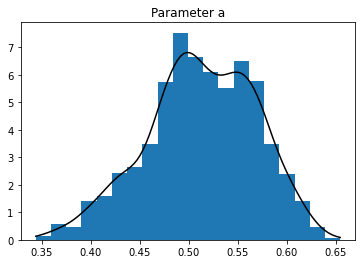

50% centred quantiles 0.18384935660672802 0.21816029710721144
90% centred quantiles 0.16635953278474236 0.2561221320086267


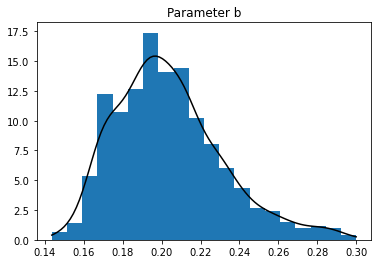

50% centred quantiles 29.544455489912806 58.098043731157006
90% centred quantiles 19.36705485979063 155.9849582797499


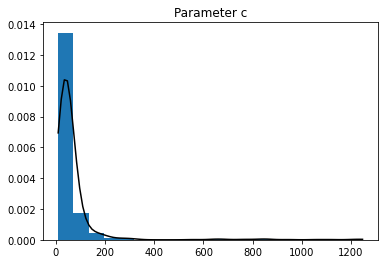

50% centred quantiles -0.025395869578955926 -0.017336684051384717
90% centred quantiles -0.036094177825290875 -0.013861779135876467


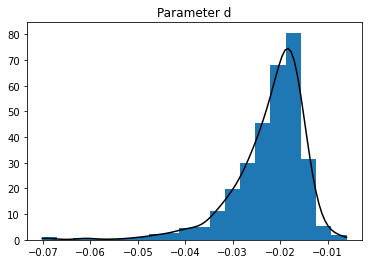

In [43]:
for P in Params.columns:
    
    
    Ps = Params[P]
    P_range = np.linspace(min(Ps), max(Ps),100)
    KDE = gaussian_kde(Ps)(P_range)
    
    print("50% centred quantiles", np.quantile(Ps, 0.25), 
          np.quantile(Ps, 0.75))
    print("90% centred quantiles", np.quantile(Ps, 0.05), 
          np.quantile(Ps, 0.95))
    plt.hist(Ps,bins=20, density= True)
    plt.plot(P_range, KDE, c="k")
    plt.title("Parameter "+str(P))
    plt.show()

### In more detail for c

In [44]:
np.quantile(Params["c"], 0.25), np.quantile(Params["c"], 0.75)

(29.544455489912806, 58.098043731157006)

[1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.16227766e+04 3.98107171e+04 5.01187234e+04
 6.30957344e+04 7.94328235e+04]


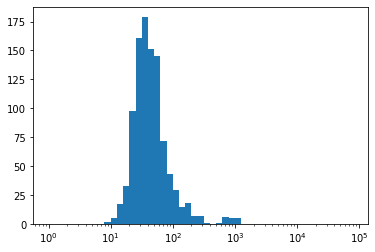

In [45]:
bins = 10**(np.arange(0,5,0.1))
print(bins)
plt.xscale('log')
plt.hist(Params["c"],bins=bins) 


plt.show()

### Analysis of the Curve

When does f(x) = y_est actually change? 
f(-infinity) = b and f(infinity) = a + b. We can now calculate the standard deviations of b and a+b via the bootstrap estimations and check when y_est exceeds b + sd(b) and reaches a+b - sd(a+b).

In [46]:
print(np.mean(Params["b"]), np.std(Params["b"]))
print(np.mean(Params["b"]+Params["a"]), np.std(Params["b"]+Params["a"]))

Thresh1 = np.mean(Params["b"]) + np.std(Params["b"])
Thresh2 = np.mean(Params["b"]+Params["a"]) - np.std(Params["b"]+Params["a"])
print(Thresh1, Thresh2)

def f1(x):
    # first threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh1)

T1 = opt.root(f1, -0.5)

def f2(x):
    # second threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh2)

T2 = opt.root(f2, 0.5)

0.20363866976812234 0.027475900444418975
0.7162729289604549 0.040323856624204006
0.2311145702125413 0.6759490723362509


C:\Users\Tobias\AppData\Local\Temp/ipykernel_23168/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


In [47]:
Timeframe = (T2["x"] -T1["x"])[0]
t_2, t_1 = T2["x"], T1["x"]
# scale this back to original time
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*Timeframe), "years.")

Most of the cultural evolution takes place in a time interval of  1242.0 years.


## Bootstrapping the Time Interval

Now we can repeat this task, but 

-> Calculate the time thresholds T1/T2 for every single Bootstrapped Data and therefore calculate a time interval with standard deviation

In [48]:
def fBT1(x):
    # first threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh1)

def fBT2(x):
    # second threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh2)


In [49]:
np.random.seed(1234)
random.seed(1234)
nBT = 1000 # how many Bootstraps
Successes = 0

Params2 = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters

for i in range(nBT):
    
    # Select the random NGAs
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection: # combine them to a data frame
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0
    
    # Time Intervals
    T1 = opt.root(fBT1, t_1)
    T2 = opt.root(fBT2, t_2)
    
    # only add results, if opt.root is successful:
    if T1["success"] and T2["success"]:
        Successes += 1
        Params2 = pd.concat([Params2,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_], "T1":T1["x"], "T2":T2["x"]})])    
        print(a_, b_, c_, d_, T1, T2)
        print("-----------------")


0.5712661810730858 0.18931160210855255 26.779471150548076 -0.021155566817284765     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([3.00348912e-11])
       r: array([-1.03754237])
  status: 1
 success: True
       x: array([-0.11596313])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.51132448e-13])
       r: array([-1.93057538])
  status: 1
 success: True
       x: array([0.04416484])
-----------------
0.5501522764666225 0.20230157140027924 15.884470410801352 -0.03408751019547134     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-1.07345521e-11])
       r: array([-0.43370965])
  status: 1
 success: True
       x: array([-0.21637715])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.04472986e-10])
       r: arra

C:\Users\Tobias\AppData\Local\Temp/ipykernel_23168/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.5152869187158649 0.20470577329057862 43.31108588930579 -0.021626587958614614     fjac: array([[-1.]])
     fun: array([-2.77555756e-16])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([8.74476047e-11])
       r: array([-1.08517721])
  status: 1
 success: True
       x: array([-0.08900925])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.11943788e-12])
       r: array([-1.74452915])
  status: 1
 success: True
       x: array([0.03309829])
-----------------
0.5160587510010455 0.19680137256043162 44.35316118594904 -0.01911533236143239     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([8.0979945e-12])
       r: array([-1.42070551])
  status: 1
 success: True
       x: array([-0.07868011])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.40172335e-13])
       r: array(

0.49591719194051515 0.21851692262609165 32.37937216014402 -0.02179705515548299     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([1.41519019e-11])
       r: array([-0.39754277])
  status: 1
 success: True
       x: array([-0.13443568])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.12995169e-11])
       r: array([-1.14941875])
  status: 1
 success: True
       x: array([0.05465158])
-----------------
0.5302076359545399 0.19353947530189516 45.457715376054324 -0.016227257729553593     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([1.94871896e-13])
       r: array([-1.58702869])
  status: 1
 success: True
       x: array([-0.0728386])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-9.23705556e-14])
  

0.6067882872809449 0.16810808882037948 29.59947463367554 -0.01663922774482224     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([7.10251302e-12])
       r: array([-1.67130957])
  status: 1
 success: True
       x: array([-0.08945506])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([7.77156117e-15])
       r: array([-2.45119905])
  status: 1
 success: True
       x: array([0.03861787])
-----------------
0.5053516840181147 0.18794303444836147 68.52191502723807 -0.018523339662600138     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([-1.3184176e-11])
       r: array([-2.70547943])
  status: 1
 success: True
       x: array([-0.0531221])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-3.65791841e-11])
  

0.50958273737405 0.19719309915920563 38.92520980387398 -0.01836736147187595     fjac: array([[-1.]])
     fun: array([-5.05151476e-15])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-5.19587734e-10])
       r: array([-1.23249312])
  status: 1
 success: True
       x: array([-0.08620663])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.27762245e-11])
       r: array([-1.12735023])
  status: 1
 success: True
       x: array([0.05209617])
-----------------
0.5038305672276531 0.20224807668981798 62.243112844465706 -0.01700270982858863     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-1.85791105e-11])
       r: array([-1.69379554])
  status: 1
 success: True
       x: array([-0.06199657])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([8.21565038e-15])
       r: arra

0.6095168142217935 0.21060969329157486 13.729817960036007 -0.018040265279243486     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-5.59413627e-13])
       r: array([-0.27205733])
  status: 1
 success: True
       x: array([-0.26260168])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.88498131e-15])
       r: array([-1.5112844])
  status: 1
 success: True
       x: array([0.06730116])
-----------------
0.5049962412938293 0.17530297166043776 68.9820095444762 -0.016188597787421877     fjac: array([[-1.]])
     fun: array([-1.38777878e-16])
 message: 'The solution converged.'
    nfev: 24
     qtf: array([7.77476139e-11])
       r: array([-3.42450576])
  status: 1
 success: True
       x: array([-0.04642043])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.04103401e-12])
       r: array([-0.2974968]

0.5446454099054605 0.1709206694378613 42.83049523889701 -0.02252968049588639     fjac: array([[-1.]])
     fun: array([-5.19029264e-15])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([7.20663668e-10])
       r: array([-2.29321715])
  status: 1
 success: True
       x: array([-0.07122037])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([5.32682787e-11])
       r: array([-1.57338843])
  status: 1
 success: True
       x: array([0.03689891])
-----------------
0.4956371690371237 0.20424452889408207 66.80782009225838 -0.018013158825468112     fjac: array([[-1.]])
     fun: array([3.85802501e-15])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([4.24123653e-10])
       r: array([-1.69779374])
  status: 1
 success: True
       x: array([-0.06080896])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-4.857758

0.5417961028774431 0.19101135390985055 18.904182992691368 -0.029645723293358173     fjac: array([[-1.]])
     fun: array([5.4678484e-15])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([6.11738438e-10])
       r: array([-0.70199707])
  status: 1
 success: True
       x: array([-0.16329507])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([9.63673585e-14])
       r: array([-0.96206082])
  status: 1
 success: True
       x: array([0.08373959])
-----------------
0.6155763300436023 0.16245624239816378 28.658886453190874 -0.01825716567763687     fjac: array([[-1.]])
     fun: array([-2.49800181e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.06299108e-10])
       r: array([-1.7482107])
  status: 1
 success: True
       x: array([-0.090666])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.50830476e-14])
       r: array([-2

0.5232115447205619 0.18459268296690554 28.68925858238236 -0.022710629034964194     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([2.02698969e-13])
       r: array([-1.21600422])
  status: 1
 success: True
       x: array([-0.10381913])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([5.67679237e-12])
       r: array([-0.85825944])
  status: 1
 success: True
       x: array([0.07265504])
-----------------
0.5076608251751574 0.2019516089746532 26.502801238611617 -0.03327253649911051     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([3.10518278e-12])
       r: array([-0.72850062])
  status: 1
 success: True
       x: array([-0.13883694])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.99760217e-14])
       r: array([-0.83301269])
  status: 

0.5244791382810168 0.18731963670567683 58.44061900886486 -0.0239101216751031     fjac: array([[-1.]])
     fun: array([-1.1185497e-14])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([9.04050557e-10])
       r: array([-2.34571729])
  status: 1
 success: True
       x: array([-0.06490374])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-1.67743597e-12])
       r: array([-1.95187346])
  status: 1
 success: True
       x: array([0.02078942])
-----------------
0.5146795671157206 0.20278022675335164 22.453180894877047 -0.027096144563963687     fjac: array([[-1.]])
     fun: array([-7.77156117e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-1.45906592e-10])
       r: array([-0.60116891])
  status: 1
 success: True
       x: array([-0.15370823])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.05024886e-12])
       r: arr

0.5631339681746733 0.15671542402343713 46.2331197887638 -0.01816833354693408     fjac: array([[-1.]])
     fun: array([-2.35922393e-15])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([4.84012247e-10])
       r: array([-2.98527835])
  status: 1
 success: True
       x: array([-0.05888321])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-3.30846461e-14])
       r: array([-1.87142329])
  status: 1
 success: True
       x: array([0.03526592])
-----------------
0.5253168830803087 0.19804216163906666 20.120721523799315 -0.04090895249846877     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.72207257e-12])
       r: array([-0.62354631])
  status: 1
 success: True
       x: array([-0.1751127])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([7.10542736e-15])
       r: array([-0.86783106])

0.5446362103137766 0.16517935503398515 30.950745065424766 -0.02918315070897606     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([2.06584749e-13])
       r: array([-1.79368567])
  status: 1
 success: True
       x: array([-0.09323342])     fjac: array([[-1.]])
     fun: array([-7.77156117e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.594328e-10])
       r: array([-0.98301921])
  status: 1
 success: True
       x: array([0.05848817])
-----------------
0.5285419829699961 0.18442913996623278 30.630049714441327 -0.027042170299144328     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-7.36605221e-13])
       r: array([-1.30366885])
  status: 1
 success: True
       x: array([-0.10324885])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([5.76670933e-11])
 

0.5637395240760437 0.19587036231251764 22.696659816214872 -0.019375729377869     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.98596695e-12])
       r: array([-0.74991533])
  status: 1
 success: True
       x: array([-0.13867666])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.88102875e-13])
       r: array([-1.61702977])
  status: 1
 success: True
       x: array([0.05760385])
-----------------
0.5438109471530698 0.17794749748739636 80.94443579700739 -0.017309315096229422     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 38
     qtf: array([-3.84764443e-11])
       r: array([-3.88282259])
  status: 1
 success: True
       x: array([-0.04476369])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-9.79253345e-11])
 

0.5495448733141283 0.21165932398542225 23.365786261952312 -0.03425902190036039     fjac: array([[-1.]])
     fun: array([4.4408921e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([9.90745264e-11])
       r: array([-0.43849157])
  status: 1
 success: True
       x: array([-0.17570213])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([4.21884749e-15])
       r: array([-1.683011])
  status: 1
 success: True
       x: array([0.03827697])
-----------------
0.5269548814815613 0.19827084406108536 57.874227060750265 -0.014318406138419159     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([1.1260326e-11])
       r: array([-1.78233142])
  status: 1
 success: True
       x: array([-0.06116136])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([3.50830476e-14])
       

0.5669699710865869 0.2092491923376751 32.74998896513666 -0.013448432691511122     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([2.35256259e-13])
       r: array([-0.68847473])
  status: 1
 success: True
       x: array([-0.11164917])     fjac: array([[-1.]])
     fun: array([1.44328993e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([4.26304991e-10])
       r: array([-2.70307927])
  status: 1
 success: True
       x: array([0.03350789])
-----------------
0.551973299302062 0.20004205209113468 32.165056771414726 -0.018099346792464242     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([8.11409273e-12])
       r: array([-0.94318749])
  status: 1
 success: True
       x: array([-0.10574837])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([5.55111512e-15])
       r: array([

0.47451249178700367 0.2037349011696803 43.443140782189 -0.02646476824084055     fjac: array([[-1.]])
     fun: array([-5.85642645e-15])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([5.47394352e-10])
       r: array([-1.12083826])
  status: 1
 success: True
       x: array([-0.09075697])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([8.43769499e-15])
       r: array([-0.09936266])
  status: 1
 success: True
       x: array([0.09611509])
-----------------
0.5768726999026904 0.20260187928367787 33.13400471481303 -0.008270959952998435     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.26010313e-14])
       r: array([-0.89804463])
  status: 1
 success: True
       x: array([-0.09750203])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.83582055e-13])
       r: array(

0.5649884677465049 0.20176066286659616 21.893570746743276 -0.015703219265471267     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.97869499e-13])
       r: array([-0.60927247])
  status: 1
 success: True
       x: array([-0.14834611])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([5.10036458e-13])
       r: array([-1.6684535])
  status: 1
 success: True
       x: array([0.05979588])
-----------------
0.5996030878406885 0.17829481777514225 33.03381068036602 -0.018716087223798885     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([1.03084208e-12])
       r: array([-1.59113265])
  status: 1
 success: True
       x: array([-0.08946685])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.28119737e-12])
       r: array([-2.795148

0.5334473165743767 0.18915421129041285 56.02511570856693 -0.017413362693129156     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([2.24681385e-13])
       r: array([-2.16591989])
  status: 1
 success: True
       x: array([-0.06133492])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([4.74065232e-14])
       r: array([-2.38512814])
  status: 1
 success: True
       x: array([0.02444496])
-----------------
0.5822056727329935 0.18856616682768731 29.1235818546499 -0.017388647516829732     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([1.24067423e-14])
       r: array([-1.14860224])
  status: 1
 success: True
       x: array([-0.10461322])     fjac: array([[-1.]])
     fun: array([-2.77555756e-15])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-4.59827509e-10])
       r: array([-2.311791

0.5836133247384857 0.19008407820287776 24.57746473515834 -0.01263279396556678     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([2.17356688e-11])
       r: array([-0.93752986])
  status: 1
 success: True
       x: array([-0.11768941])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([6.66133815e-15])
       r: array([-2.00003144])
  status: 1
 success: True
       x: array([0.05261131])
-----------------
0.48347684212465086 0.2043189504788634 49.186996443295364 -0.029110773865906173     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([1.65201186e-13])
       r: array([-1.24494916])
  status: 1
 success: True
       x: array([-0.08676315])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.48769885e-14])
       r: array([-0.5684265

0.5649387843380377 0.18555847446750198 26.417383750094196 -0.019742283166759786     fjac: array([[-1.]])
     fun: array([-1.38777878e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([5.88552262e-11])
       r: array([-1.1064281])
  status: 1
 success: True
       x: array([-0.1118671])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.56541446e-14])
       r: array([-1.70949421])
  status: 1
 success: True
       x: array([0.05156518])
-----------------
0.5563817450853557 0.17959194900503642 16.93144972531366 -0.03229114812780284     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([3.5274561e-12])
       r: array([-0.79156995])
  status: 1
 success: True
       x: array([-0.16708519])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.7966518e-13])
       r: array([-0

0.5676687291525515 0.19693931220635624 22.92126961642265 -0.027023830520177487     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([6.01824146e-13])
       r: array([-0.73618111])
  status: 1
 success: True
       x: array([-0.14691007])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.77209375e-12])
       r: array([-1.71478951])
  status: 1
 success: True
       x: array([0.04657261])
-----------------
0.4671738268146123 0.22012182714696912 52.86285462813408 -0.01817640347831411     fjac: array([[-1.]])
     fun: array([-4.71844785e-16])
 message: 'The solution converged.'
    nfev: 23
     qtf: array([8.23522361e-11])
       r: array([-0.56743744])
  status: 1
 success: True
       x: array([-0.08865414])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([4.6629367e-15])
       r: array([-0.5852448])

0.5738273398158091 0.16637377161032557 41.17492724620642 -0.018496967131522983     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([3.9465653e-13])
       r: array([-2.36494607])
  status: 1
 success: True
       x: array([-0.06858149])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-3.40083517e-12])
       r: array([-2.34934617])
  status: 1
 success: True
       x: array([0.0317949])
-----------------
0.5975619316022723 0.1746194304932891 37.86254031683821 -0.014179753016402641     fjac: array([[-1.]])
     fun: array([-8.77076189e-15])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-8.98196767e-10])
       r: array([-1.93679903])
  status: 1
 success: True
       x: array([-0.0738532])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-9.44300194e-12])
       r: array(

0.5887870473595165 0.16908022300797831 33.36950120101514 -0.027904681197168785     fjac: array([[-1.]])
     fun: array([8.65973959e-15])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([9.82288195e-10])
       r: array([-1.85193875])
  status: 1
 success: True
       x: array([-0.09200642])     fjac: array([[-1.]])
     fun: array([2.22044605e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-5.72160097e-11])
       r: array([-2.35324991])
  status: 1
 success: True
       x: array([0.02671199])
-----------------
0.5713856167344473 0.1812625312548514 24.783523364927255 -0.02112927051861964     fjac: array([[-1.]])
     fun: array([7.21644966e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.95396227e-10])
       r: array([-1.12770974])
  status: 1
 success: True
       x: array([-0.1158581])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([8.27116153e-14])
     

0.4856995168809851 0.20808895206040748 25.115969127158415 -0.03296710793176125     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([3.40522055e-12])
       r: array([-0.55089494])
  status: 1
 success: True
       x: array([-0.15242955])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([9.373613e-13])
       r: array([-0.43159717])
  status: 1
 success: True
       x: array([0.09709994])
-----------------
0.5998851348640494 0.16912071765815967 42.54112949073235 -0.017670757061631136     fjac: array([[-1.]])
     fun: array([-1.88737914e-15])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([3.88450994e-10])
       r: array([-2.36475502])
  status: 1
 success: True
       x: array([-0.06845975])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-7.37365724e-12])
       r: arra

0.477230435378415 0.21650175677707276 43.61001759942028 -0.028733747049229638     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([9.75933223e-12])
       r: array([-0.61775272])
  status: 1
 success: True
       x: array([-0.10795871])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.88578059e-15])
       r: array([-0.74662376])
  status: 1
 success: True
       x: array([0.04583111])
-----------------
0.5280945311435721 0.18199039871940384 51.83233689814386 -0.02096210987283521     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([-7.63075714e-12])
       r: array([-2.30936588])
  status: 1
 success: True
       x: array([-0.06489776])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.4321877e-14])
       r: array(

0.5631495504433902 0.1765599563859925 45.668610365544446 -0.022418437119596072     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([1.30717659e-12])
       r: array([-2.25007761])
  status: 1
 success: True
       x: array([-0.07130211])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.08244858e-10])
       r: array([-2.58216168])
  status: 1
 success: True
       x: array([0.02265087])
-----------------
0.5655203053119201 0.17653325026864894 32.47553099945686 -0.023955786702886554     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-2.43613463e-12])
       r: array([-1.60147819])
  status: 1
 success: True
       x: array([-0.09282482])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([8.68194405e-14])
 

0.5674412835541358 0.20015139560707682 23.746644086424734 -0.01980386820265802     fjac: array([[-1.]])
     fun: array([1.38777878e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([5.43296241e-11])
       r: array([-0.69514874])
  status: 1
 success: True
       x: array([-0.13991462])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.01977204e-10])
       r: array([-1.82476284])
  status: 1
 success: True
       x: array([0.0495569])
-----------------
0.5392163954361798 0.17371901486037902 42.01106570706591 -0.020879264361124097     fjac: array([[-1.]])
     fun: array([-1.94289029e-16])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([-8.30324143e-11])
       r: array([-2.15458416])
  status: 1
 success: True
       x: array([-0.07152319])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([9.06918984e-12])
  

0.49487291881495976 0.1901611371397558 34.57844839645322 -0.02468753198416866     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-9.76330128e-13])
       r: array([-1.29891545])
  status: 1
 success: True
       x: array([-0.09425353])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([2.77555756e-15])
       r: array([-0.30837752])
  status: 1
 success: True
       x: array([0.09038846])
-----------------
0.5336546363701299 0.21584853246521765 32.280556498735 -0.024456286611815387     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([5.78176396e-13])
       r: array([-0.47869908])
  status: 1
 success: True
       x: array([-0.13365808])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-2.5313085e-14])
       r: array([-2.047106])
  status: 1


0.5495512690001696 0.1938293120826762 39.864254082030854 -0.019878288825381524     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([9.02333763e-14])
       r: array([-1.38550513])
  status: 1
 success: True
       x: array([-0.0856075])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-4.28876934e-11])
       r: array([-2.3582715])
  status: 1
 success: True
       x: array([0.02946617])
-----------------
0.5200093411272929 0.19532447441285003 26.921001531421297 -0.026611376797021375     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.70130299e-11])
       r: array([-0.89719201])
  status: 1
 success: True
       x: array([-0.12337102])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.35367281e-14])
  

0.5714384632174545 0.2060969597608043 23.652037001771056 -0.030756860311525698     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([6.98996416e-13])
       r: array([-0.56581191])
  status: 1
 success: True
       x: array([-0.16113927])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.54125601e-11])
       r: array([-1.97558376])
  status: 1
 success: True
       x: array([0.03399481])
-----------------
0.47338535938627035 0.21655761890203318 46.460589441407656 -0.02334704575723913     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-3.82188725e-12])
       r: array([-0.65552657])
  status: 1
 success: True
       x: array([-0.09761661])     fjac: array([[-1.]])
     fun: array([-4.4408921e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([8.64245342e-11])
       r: arr

0.5421149348770402 0.2104620503989512 18.20499025226084 -0.044824259782895615     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-3.02535774e-14])
       r: array([-0.36165556])
  status: 1
 success: True
       x: array([-0.22218222])     fjac: array([[-1.]])
     fun: array([-1.88737914e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([4.45472326e-10])
       r: array([-1.19783072])
  status: 1
 success: True
       x: array([0.05427619])
-----------------
0.5251318921118647 0.18158791074607247 31.404542399531824 -0.03290687893506805     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([1.81354931e-13])
       r: array([-1.40867144])
  status: 1
 success: True
       x: array([-0.10493713])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.32682762e-11])
       r: array

0.5206828001278581 0.22283612423981178 14.840399967940753 -0.045959947761112264     fjac: array([[-1.]])
     fun: array([4.30211422e-15])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-2.75780537e-10])
       r: array([-0.12090403])
  status: 1
 success: True
       x: array([-0.32394833])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([9.84976545e-11])
       r: array([-0.87263525])
  status: 1
 success: True
       x: array([0.08226972])
-----------------
0.5594876711010216 0.189596687917873 43.84157830788762 -0.018695500235457633     fjac: array([[-1.]])
     fun: array([-2.49800181e-16])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([8.6260582e-11])
       r: array([-1.68514153])
  status: 1
 success: True
       x: array([-0.07626169])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.64679381e-12])
  

0.5747753956898186 0.17467995077659831 24.418879428407696 -0.026129218009523506     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([1.38578038e-12])
       r: array([-1.24276383])
  status: 1
 success: True
       x: array([-0.11694215])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.84297022e-14])
       r: array([-1.56539135])
  status: 1
 success: True
       x: array([0.05248915])
-----------------
0.48268282146858416 0.19763242148002344 35.27544341196564 -0.029680397463001523     fjac: array([[-1.]])
     fun: array([-3.24740235e-15])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-3.8571904e-10])
       r: array([-1.09915949])
  status: 1
 success: True
       x: array([-0.10328563])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([2.06940021e-11])
       r: a

0.6191456852193308 0.1653542893577687 25.638120031369997 -0.023834589196447504     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-5.19065346e-12])
       r: array([-1.50690031])
  status: 1
 success: True
       x: array([-0.10691551])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([6.07736084e-13])
       r: array([-2.2951079])
  status: 1
 success: True
       x: array([0.03655818])
-----------------
0.5856421597228892 0.1696145763224895 40.26893117021566 -0.020802419282714802     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([6.08152417e-13])
       r: array([-2.21647025])
  status: 1
 success: True
       x: array([-0.07401282])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-6.88338275e-14])
       r: arra

0.5502039775028401 0.1868855098030471 62.10544187564557 -0.016760246887284443     fjac: array([[-1.]])
     fun: array([-1.49880108e-15])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([2.94536867e-10])
       r: array([-2.52606696])
  status: 1
 success: True
       x: array([-0.05600166])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.03683728e-12])
       r: array([-3.37520124])
  status: 1
 success: True
       x: array([0.01672022])
-----------------
0.5729317618012514 0.22575820143689765 20.866381514270135 -0.01278478582822086     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-6.85562718e-15])
       r: array([-0.11072311])
  status: 1
 success: True
       x: array([-0.23625848])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.29671829e-11])
       r: array([-2.012474

0.5699719609756108 0.16817083627384893 28.546078731499236 -0.026760704313170687     fjac: array([[-1.]])
     fun: array([3.05311332e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([1.27553107e-10])
       r: array([-1.59836698])
  status: 1
 success: True
       x: array([-0.09984694])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([5.14361886e-11])
       r: array([-1.58166377])
  status: 1
 success: True
       x: array([0.04679723])
-----------------
0.52888293268609 0.20162459257725895 27.806833492107245 -0.03462438817221551     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([-2.86880242e-11])
       r: array([-0.77429782])
  status: 1
 success: True
       x: array([-0.1363743])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.73034936e-14])
   

0.49817544868969454 0.20266114972125512 51.17784480672983 -0.01821849141992359     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([7.74971753e-12])
       r: array([-1.37301538])
  status: 1
 success: True
       x: array([-0.07300534])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.98570066e-14])
       r: array([-1.21005965])
  status: 1
 success: True
       x: array([0.03933253])
-----------------
0.491999233369904 0.21056961981489242 61.43672366287322 -0.021659073624417106     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-9.80260317e-12])
       r: array([-1.20950535])
  status: 1
 success: True
       x: array([-0.072658])     fjac: array([[-1.]])
     fun: array([4.4408921e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-1.03273723e-10])
       r: array([-1.54695236]

0.5121773977286802 0.17419380372634338 42.868777870722354 -0.024015797106487193     fjac: array([[-1.]])
     fun: array([-1.08246745e-15])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([2.70402756e-10])
       r: array([-2.1689497])
  status: 1
 success: True
       x: array([-0.07251732])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([5.32907052e-15])
       r: array([-0.43769249])
  status: 1
 success: True
       x: array([0.06635723])
-----------------
0.4971649181080835 0.18717918578940873 76.88796867485405 -0.017761935607310982     fjac: array([[-1.]])
     fun: array([9.15933995e-16])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([2.27009272e-10])
       r: array([-3.07956099])
  status: 1
 success: True
       x: array([-0.04811361])     fjac: array([[-1.]])
     fun: array([3.33066907e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-4.98325825e-11])
 

0.597419915778439 0.16160502244976083 25.54354607957743 -0.03608490361640604     fjac: array([[-1.]])
     fun: array([-1.94289029e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-9.46662471e-11])
       r: array([-1.56893593])
  status: 1
 success: True
       x: array([-0.11545769])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([8.93385366e-12])
       r: array([-1.82696379])
  status: 1
 success: True
       x: array([0.03528883])
-----------------
0.49354445059015484 0.22405303655495148 41.12732155539726 -0.020075155783414244     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([3.21251359e-12])
       r: array([-0.28626635])
  status: 1
 success: True
       x: array([-0.12298824])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.5920377e-12])
       r: array

In [50]:
print(Successes)
print(Params2.round(2))

724
       a     b      c     d    T1    T2
0   0.57  0.19  26.78 -0.02 -0.12  0.04
0   0.55  0.20  15.88 -0.03 -0.22  0.08
0   0.54  0.17  41.98 -0.02 -0.07  0.04
0   0.53  0.19  61.92 -0.02 -0.06  0.01
0   0.48  0.21  94.14 -0.02 -0.06  0.01
..   ...   ...    ...   ...   ...   ...
0   0.47  0.22  20.71 -0.05 -0.24  0.10
0   0.54  0.22  22.73 -0.03 -0.20  0.05
0   0.52  0.19  13.39 -0.04 -0.23  0.15
0   0.57  0.20  32.05 -0.02 -0.11  0.03
0   0.54  0.17  27.83 -0.03 -0.11  0.06

[724 rows x 6 columns]


In [51]:
T2_scaled, T1_scaled = np.mean(Params2["T2"])*T, T*np.mean(Params2["T1"])

T1_start_scaled = T*np.mean(Params2["T1"]) - T*np.std(Params2["T1"])
T2_end_scaled = T*np.mean(Params2["T2"]) + T*np.std(Params2["T2"])

In [52]:
TimeframeBT = Params2["T2"]-Params2["T1"]
print(np.mean(TimeframeBT))

# times T for the transformation to years
#print("Most of the cultural evolution takes place in a time interval of ", np.round(T*np.mean(TimeframeBT)),
 #     u"\u00B1",np.round(T*np.std(TimeframeBT)), "years.")

0.1596195510270393


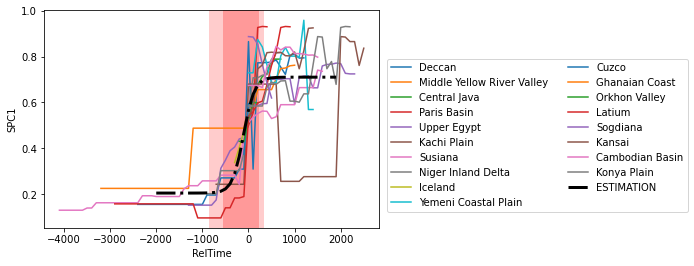

In [53]:
DF_Out_cutout = pd.DataFrame(columns=["NGA","RelTime","SPC1"])

for N in list(set(Cutout_DF["NGA"])):
    DF = Cutout_DF[Cutout_DF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    DF_Out_cutout = pd.concat((DF_Out_cutout, DF[["NGA", "RelTime", "SPC1"]]))
    #print(N)
    
plt.plot(TimeRange, New_Fit, "-.",label="ESTIMATION", c = "k", linewidth=3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.ylabel("SPC1")
plt.xlabel("RelTime")
plt.axvspan(T1_scaled, T2_scaled, facecolor='r', alpha=0.4)
plt.axvspan(T2_scaled, T2_end_scaled, facecolor='r', alpha=0.2)
plt.axvspan(T1_start_scaled, T1_scaled, facecolor='r', alpha=0.2)
#plt.savefig("SPC1_Time_Interval_Cutouts")
plt.show()

In [54]:
Cutout_CCDF.index = np.arange(0,len(Cutout_CCDF["NGA"]))
Cutout_CCDF.to_csv("Cutouts_CC_with_Reltime.csv")

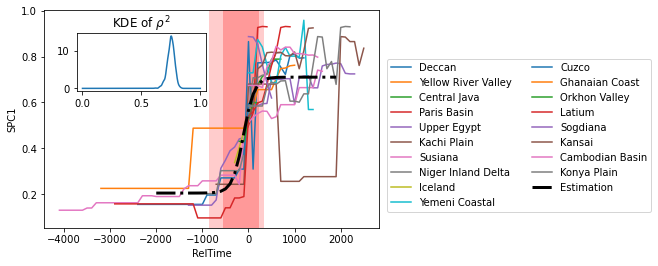

In [55]:
fig, ax1 = plt.subplots()
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.2, 0.6, 0.3, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])


for N in list(set(Cutout_DF["NGA"])):
    DF = Cutout_DF[Cutout_DF["NGA"] == N]
 
      # some abbreviations
    if N=="Middle Yellow River Valley":
        name = "Yellow River Valley"
    elif N == "Yemeni Coastal Plain":
        name = "Yemeni Coastal"
    else:
        name = N
    ax1.plot(DF["RelTime"],   
             DF["SPC1"], label=name)
    DF_Out_cutout = pd.concat((DF_Out_cutout, DF[["NGA", "RelTime", "SPC1"]]))
    
    
ax1.plot(TimeRange, New_Fit, "-.",label="Estimation", c = "k", linewidth=3)
lgd = ax1.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
ax1.set_ylabel("SPC1")
ax1.set_xlabel("RelTime")
ax1.axvspan(T1_scaled, T2_scaled, facecolor='r', alpha=0.4)
ax1.axvspan(T2_scaled, T2_end_scaled, facecolor='r', alpha=0.2)
ax1.axvspan(T1_start_scaled, T1_scaled, facecolor='r', alpha=0.2)

ax2.plot(np.arange(0.0,1,0.001),
    gaussian_kde(RhoSqList)(np.arange(0.0,1,0.001)))
ax2.set_title(r'KDE of $\rho^2$')

#plt.savefig("Cutout_Logistic_Times_Inset.pdf",bbox_extra_artists=(lgd,),dpi=300,bbox_inches='tight')
plt.show()

In [56]:
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*np.mean(TimeframeBT)), 
      "years. The interval's start and end times are", np.round(T1_scaled), "and", np.round(T2_scaled),
      "The lower boundary's uncertainty is", np.round(T1_start_scaled), "and the upper boundary's uncertainty is", 
     np.round(T2_end_scaled), "years. Thus, the upper estimate for the time range is", np.round(T2_end_scaled-T1_start_scaled), "years.")

Most of the cultural evolution takes place in a time interval of  798.0 years. The interval's start and end times are -562.0 and 236.0 The lower boundary's uncertainty is -851.0 and the upper boundary's uncertainty is 347.0 years. Thus, the upper estimate for the time range is 1198.0 years.
